In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from datasets import load_dataset
from torch.utils.data import random_split
from torchvision.transforms import v2
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [2]:
ds = load_dataset("urbanstevie/reference_dataset")

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
from utilities import set_seed
set_seed(42)

42

## Sprinkles method got from:
[Here](https://github.com/jcgy/sprinkles)

In [4]:
import torch
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt
import numpy as np

def sprinkles(
    img,
    size,
    perc,
    channels=3,
    mode="random",
    width=1,
    background_weight=0.1,
    normalize_weights=True,
):
    """
    img: torch.Tensor of shape (C, H, W), values in [0, 1]
    mode: "random" | "grid" | "diagonals"
    size:
        - random: sprinkle square size
        - grid/diagonals: spacing between lines
    perc:
        - random: percentage of pixels to affect
        - grid/diagonals: ignored (kept for API consistency)
    width: line thickness for grid/diagonals
    background_weight: peso fijo para el fondo (áreas no afectadas)
    normalize_weights: si True, normaliza los pesos de las áreas afectadas a [0, 1]
    """

    x = img.clone()
    C, H, W = x.shape

    mask = torch.zeros((1, H, W), dtype=torch.float32)

    # RANDOM (original behavior)
    if mode == "random":
        number_of_pixels_to_change = int(perc * H * W)
        number_of_sprinkles = max(1, number_of_pixels_to_change // (size * size))

        for _ in range(number_of_sprinkles):
            y = torch.randint(0, H - size, (1,)).item()
            x0 = torch.randint(0, W - size, (1,)).item()

            x[:, y:y + size, x0:x0 + size] = 0.0
            mask[:, y:y + size, x0:x0 + size] = 1.0

    # GRID (vertical + horizontal lines)
    elif mode == "grid":
        for y in range(0, H, size):
            y_end = min(y + width, H)
            x[:, y:y_end, :] = 0.0
            mask[:, y:y_end, :] = 1.0

        for x0 in range(0, W, size):
            x_end = min(x0 + width, W)
            x[:, :, x0:x_end] = 0.0
            mask[:, :, x0:x_end] = 1.0

    # DIAGONALS (both directions)
    elif mode == "diagonals":
        for offset in range(-H, W, size):
            for w in range(width):
                # main diagonal \
                y = torch.arange(H)
                x_diag = y + offset + w
                valid = (x_diag >= 0) & (x_diag < W)
                x[:, y[valid], x_diag[valid]] = 0.0
                mask[:, y[valid], x_diag[valid]] = 1.0

                # anti-diagonal /
                x_anti = (W - 1 - y) + offset + w
                valid = (x_anti >= 0) & (x_anti < W)
                x[:, y[valid], x_anti[valid]] = 0.0
                mask[:, y[valid], x_anti[valid]] = 1.0

    else:
        raise ValueError(f"Unknown mode: {mode}")

    # Crear matriz de pesos usando distance transform
    weights = torch.full((1, H, W), background_weight, dtype=torch.float32)
    
    # Convertir mask a numpy para usar scipy's distance_transform_edt
    mask_np = mask[0].numpy().astype(bool)
    
    if mask_np.any():  # Solo si hay áreas afectadas
        # Distance transform: calcula distancia al borde más cercano
        # Para las áreas enmascaradas (True), da valores más altos en el centro
        distances = distance_transform_edt(mask_np)
        distances = torch.from_numpy(distances).float().unsqueeze(0)
        
        # Normalizar distancias si se requiere
        if normalize_weights and distances.max() > 0:
            distances = distances / distances.max()
        
        # Aplicar las distancias solo donde hay mask
        weights = torch.where(mask > 0, distances, weights)
    
    return x, img, mask, weights

In [5]:
class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transforms=None):
        self.dataset = hf_dataset
        self.transforms = transforms
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']  # PIL Image
        
        if self.transforms:
            image = self.transforms(image)
        
        # Create masked version
        masked_image, original_image, mask, weights = sprinkles(image, size=10, perc=0.15)
        
        return {
            'masked_image': masked_image,  # X - input to U-Net
            'original_image': original_image,  # Y - target for U-Net
            'mask': mask,  # Optional: can be used for masked loss
            'weights': weights
        }


# DataModule
class DataModule(pl.LightningDataModule):
    def __init__(self, dataset_name, bs, train_split=0.70, val_split=0.15, test_split=0.15, num_workers=4):
        super().__init__()
        self.dataset_name = dataset_name
        self.bs = bs
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        # Load dataset
        ds = load_dataset(self.dataset_name)
        
        # If dataset has splits, use them
        if 'train' in ds and 'test' in ds:
            full_train = ds['train']
            self.test_data = ds['test']
            
            # Split train into train/val
            train_size = int(self.train_split / (self.train_split + self.val_split) * len(full_train))
            val_size = len(full_train) - train_size
            train_data, val_data = random_split(full_train, [train_size, val_size])
            
        else:
            # No predefined splits, create our own
            full_dataset = ds['train'] if 'train' in ds else ds[list(ds.keys())[0]]
            total_size = len(full_dataset)
            train_size = int(self.train_split * total_size)
            val_size = int(self.val_split * total_size)
            test_size = total_size - train_size - val_size
            
            train_data, val_data, test_data = random_split(
                full_dataset, 
                [train_size, val_size, test_size]
            )
            self.test_data = test_data
        
        # Define transforms
        rgb_transforms = v2.Compose([
            v2.ToImage(), 
            v2.Resize(256),
            v2.CenterCrop(224),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(
                mean=[0.34437724, 0.38029198, 0.40777111], 
                std=[0.20265734, 0.13689059, 0.11554374]
            )
        ])
        
        # Create datasets with cutouts
        self.train_ds = HFImageDataset(
            train_data, 
            transforms=rgb_transforms,
        )
        self.valid_ds = HFImageDataset(
            val_data, 
            transforms=rgb_transforms,
        )
        self.test_ds = HFImageDataset(
            test_data, 
            transforms=rgb_transforms,
        )
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds, 
            batch_size=self.bs, 
            shuffle=True, 
            num_workers=self.num_workers
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.valid_ds, 
            batch_size=self.bs, 
            shuffle=False, 
            num_workers=self.num_workers
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds, 
            batch_size=self.bs, 
            shuffle=False, 
            num_workers=self.num_workers
        )

Repo card metadata block was not found. Setting CardData to empty.
/tmp/ipykernel_797761/2477834307.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


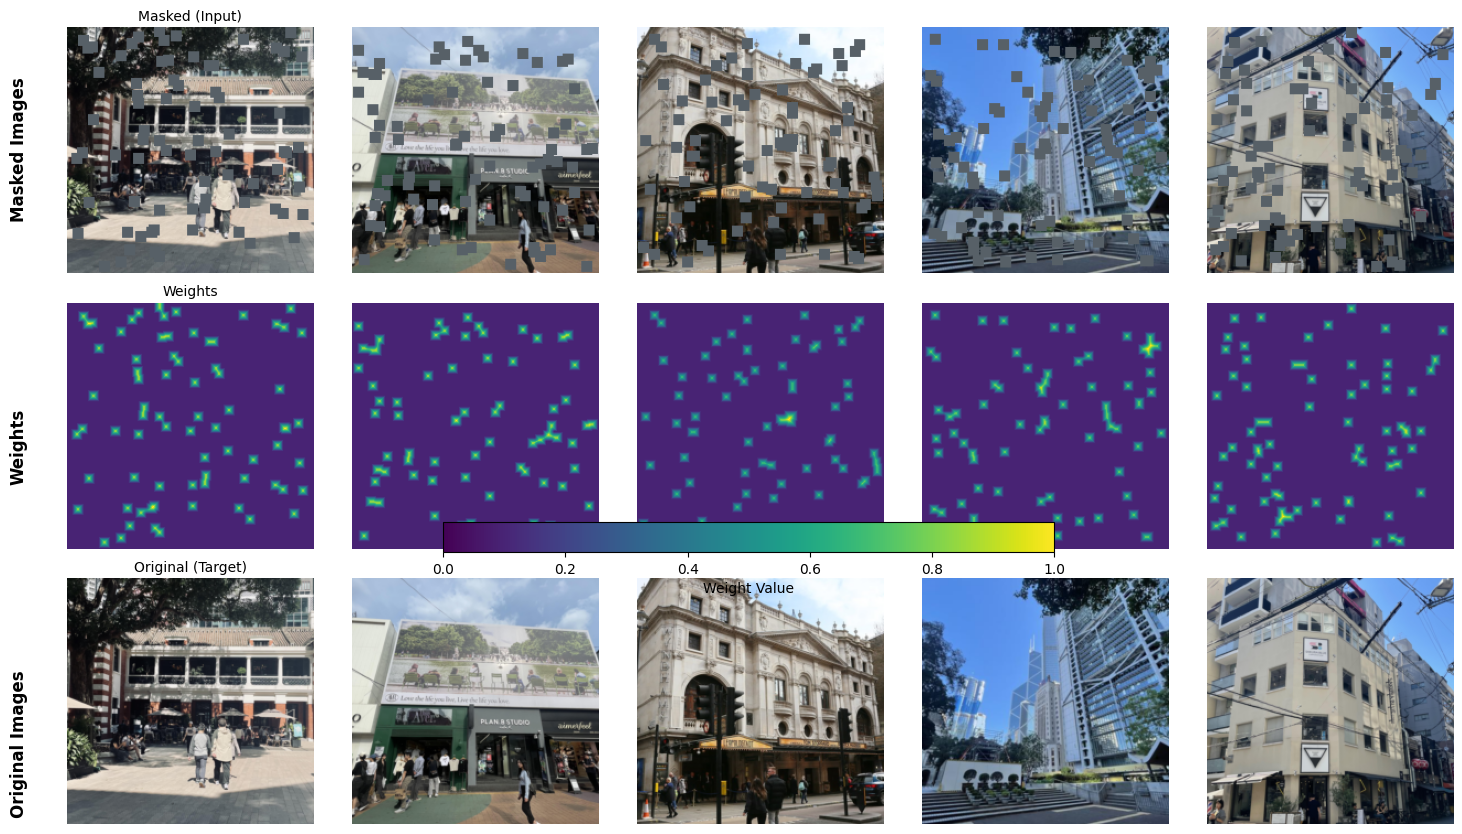

In [7]:
# Create and setup the DataModule
dm = DataModule(dataset_name="urbanstevie/reference_dataset", bs=32)
dm.setup()

# Get 5 samples from training set
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Denormalization parameters
mean = torch.tensor([0.34437724, 0.38029198, 0.40777111]).view(3, 1, 1)
std = torch.tensor([0.20265734, 0.13689059, 0.11554374]).view(3, 1, 1)

for i in range(5):
    sample = dm.train_ds[i]
    
    # Get masked, original images and weights
    masked_image = sample['masked_image']
    original_image = sample['original_image']
    weights = sample['weights']  # Shape: (1, H, W)
    
    # Denormalize for visualization
    masked_denorm = masked_image * std + mean
    original_denorm = original_image * std + mean
    
    # Clamp to valid range
    masked_denorm = torch.clamp(masked_denorm, 0, 1)
    original_denorm = torch.clamp(original_denorm, 0, 1)
    
    # Convert to numpy for plotting
    masked_np = masked_denorm.permute(1, 2, 0).numpy()
    original_np = original_denorm.permute(1, 2, 0).numpy()
    weights_np = weights[0].numpy()  # Remove channel dimension
    
    # Top row: masked images (with cutouts)
    axes[0, i].imshow(masked_np)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Masked (Input)', fontsize=10, pad=5)
    
    # Middle row: weights
    im = axes[1, i].imshow(weights_np, cmap='viridis', vmin=0, vmax=1)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Weights', fontsize=10, pad=5)
    
    # Bottom row: original images (ground truth)
    axes[2, i].imshow(original_np)
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('Original (Target)', fontsize=10, pad=5)

# Add row labels
fig.text(0.02, 0.83, 'Masked Images', va='center', rotation='vertical', fontsize=12, fontweight='bold')
fig.text(0.02, 0.50, 'Weights', va='center', rotation='vertical', fontsize=12, fontweight='bold')
fig.text(0.02, 0.17, 'Original Images', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Add colorbar for weights
cbar = fig.colorbar(im, ax=axes[1, :], orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Weight Value', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(left=0.05, bottom=0.08)
plt.show()

In [6]:
class LightningModule(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, use_weighted_loss=True):
        super().__init__()
        self.save_hyperparameters()
        
        # Creating model
        self.model = smp.Unet(
            encoder_name='resnet50',
            encoder_weights='imagenet',
            in_channels=3,
            classes=3
        )
        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return {"optimizer": optimizer}
    
    def training_step(self, batch, batch_idx):
        x = batch['masked_image']
        y = batch['original_image']
        mask = batch['mask']
        weights = batch['weights']
        
        y_hat = self(x)
        
        # Calcular loss con o sin pesos
        if self.hparams.use_weighted_loss:
            # Loss ponderado por los weights
            loss_per_pixel = F.l1_loss(y_hat, y, reduction='none')  # (B, C, H, W)
            # Expandir weights para que coincida con los canales de color
            weights_expanded = weights.expand_as(loss_per_pixel)  # (B, C, H, W)
            weighted_loss = loss_per_pixel * weights_expanded
            loss = weighted_loss.sum() / (weights_expanded.sum() + 1e-8)
        else:
            # Loss simple solo en áreas enmascaradas
            loss = (F.l1_loss(y_hat, y, reduction='none') * mask).sum() / (mask.sum() + 1e-8)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['steps'] += 1
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch['masked_image']
        y = batch['original_image']
        mask = batch['mask']
        weights = batch['weights']
        
        y_hat = self(x)
        
        # Calcular loss con o sin pesos
        if self.hparams.use_weighted_loss:
            # Loss ponderado por los weights
            loss_per_pixel = F.l1_loss(y_hat, y, reduction='none')  # (B, C, H, W)
            # Expandir weights para que coincida con los canales de color
            weights_expanded = weights.expand_as(loss_per_pixel)  # (B, C, H, W)
            weighted_loss = loss_per_pixel * weights_expanded
            loss = weighted_loss.sum() / (weights_expanded.sum() + 1e-8)
        else:
            # Loss simple solo en áreas enmascaradas
            loss = (F.l1_loss(y_hat, y, reduction='none') * mask).sum() / (mask.sum() + 1e-8)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss
    
    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 
    
    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

In [7]:
from lightning.pytorch.loggers import CSVLogger
    
pl.seed_everything(seed=42, workers=True)

# Initialize model with weighted loss enabled
lightning_module = LightningModule(learning_rate=1e-3, use_weighted_loss=True)

# Logger
csv_logger = CSVLogger(save_dir=os.getcwd(), name="denoising_weights")

# Checkpoint callback
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss', 
    mode='min', 
    filename='best_valid_loss', 
    verbose=True, 
    save_last=True
)

# Trainer
trainer = pl.Trainer(
    max_epochs=5, 
    logger=csv_logger, 
    callbacks=[model_checkpoint_callback],
)

# Data module 
dm = DataModule(dataset_name="urbanstevie/reference_dataset", bs=32)
dm.setup()

# Train
trainer.fit(lightning_module, dm)

print(f"\nBest model saved at: {model_checkpoint_callback.best_model_path}")
print(f"Best validation loss: {model_checkpoint_callback.best_model_score:.4f}")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Repo card metadata block was not found. Setting CardData to empty.
You are using a CUDA device ('NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Repo card metadata block was not found. Setting CardData to empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | Unet | 32.5 M | train
---------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.086   Total estimated model params size (MB)
223       Modules 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 1.4838


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 115: 'val_loss' reached 0.41784 (best 0.41784), saving model to '/home/alumno/Desktop/datos/Computer Vision/Final-Computer-Vision/denoising_weights/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.4170
Average training loss for epoch 0: 0.5389


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 230: 'val_loss' was not in top 1


Average validation loss for epoch 1: 0.4574
Average training loss for epoch 1: 0.3854


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 345: 'val_loss' reached 0.33063 (best 0.33063), saving model to '/home/alumno/Desktop/datos/Computer Vision/Final-Computer-Vision/denoising_weights/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 2: 0.3304
Average training loss for epoch 2: 0.3518


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 460: 'val_loss' reached 0.31737 (best 0.31737), saving model to '/home/alumno/Desktop/datos/Computer Vision/Final-Computer-Vision/denoising_weights/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 3: 0.3171
Average training loss for epoch 3: 0.3352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 575: 'val_loss' reached 0.29540 (best 0.29540), saving model to '/home/alumno/Desktop/datos/Computer Vision/Final-Computer-Vision/denoising_weights/version_1/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 4: 0.2951
Average training loss for epoch 4: 0.3191


`Trainer.fit` stopped: `max_epochs=5` reached.



Best model saved at: /home/alumno/Desktop/datos/Computer Vision/Final-Computer-Vision/denoising_weights/version_1/checkpoints/best_valid_loss.ckpt
Best validation loss: 0.2954


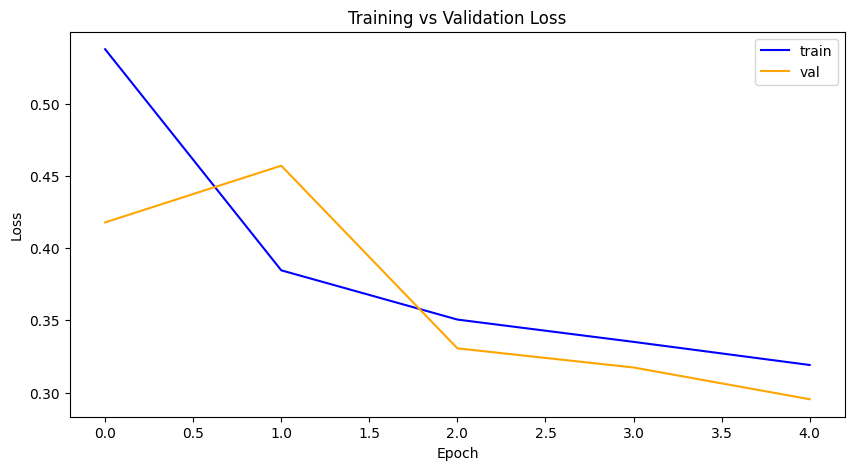

In [8]:
# Plot results
metric_df = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')
metric_df = metric_df.groupby('epoch', as_index=False).first()

f, ax = plt.subplots(1, 1, figsize=(10, 5))
metric_df.train_loss.plot(ax=ax, color='blue', label='train')
metric_df.val_loss.plot(ax=ax, color='orange', label='val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
plt.show()

In [10]:
# Load the best model
model = LightningModule.load_from_checkpoint(
    model_checkpoint_callback.best_model_path,
    use_weighted_loss=True 
)
model.cuda(0)  # Move to GPU
model.eval()

LightningModule(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [11]:
def denormalize(img, mean, std):
    """Denormalize image for visualization"""
    img = img.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)

def visualize_inpainting(model, dataloader, device='cuda', num_images=4):
    """
    Visualize inpainting results
    
    Args:
        model: Trained PyTorch Lightning model
        dataloader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        num_images: Number of images to visualize
    """
    model.eval()
    model.to(device)
    
    # Get normalization parameters (match your DataModule)
    mean = [0.34437724, 0.38029198, 0.40777111]
    std = [0.20265734, 0.13689059, 0.11554374]
    
    # Get a batch
    batch = next(iter(dataloader))
    masked_images = batch['masked_image'][:num_images].to(device)
    original_images = batch['original_image'][:num_images].to(device)
    masks = batch['mask'][:num_images].cpu()  # Para visualizar si quieres
    weights = batch['weights'][:num_images].cpu()  # Para visualizar si quieres
    
    # Get predictions
    with torch.no_grad():
        predicted_images = model(masked_images)
    
    # Move to CPU for visualization
    masked_images = masked_images.cpu()
    original_images = original_images.cpu()
    predicted_images = predicted_images.cpu()
    
    # Create figure
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))
    
    # Handle single image case
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_images):
        # Denormalize images
        masked_img = denormalize(masked_images[i], mean, std)
        original_img = denormalize(original_images[i], mean, std)
        predicted_img = denormalize(predicted_images[i], mean, std)
        
        # Convert to numpy for plotting (C, H, W) -> (H, W, C)
        masked_np = masked_img.permute(1, 2, 0).numpy()
        original_np = original_img.permute(1, 2, 0).numpy()
        predicted_np = predicted_img.permute(1, 2, 0).numpy()
        
        # Calculate MAE for this sample
        mae = torch.abs(predicted_images[i] - original_images[i]).mean().item()
        
        # Plot
        axes[i, 0].imshow(masked_np)
        axes[i, 0].set_title('Masked Input', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(predicted_np)
        axes[i, 1].set_title(f'Predicted (MAE: {mae:.4f})', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(original_np)
        axes[i, 2].set_title('Original/Target', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('inpainting_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Results saved to 'inpainting_results.png'")

Repo card metadata block was not found. Setting CardData to empty.


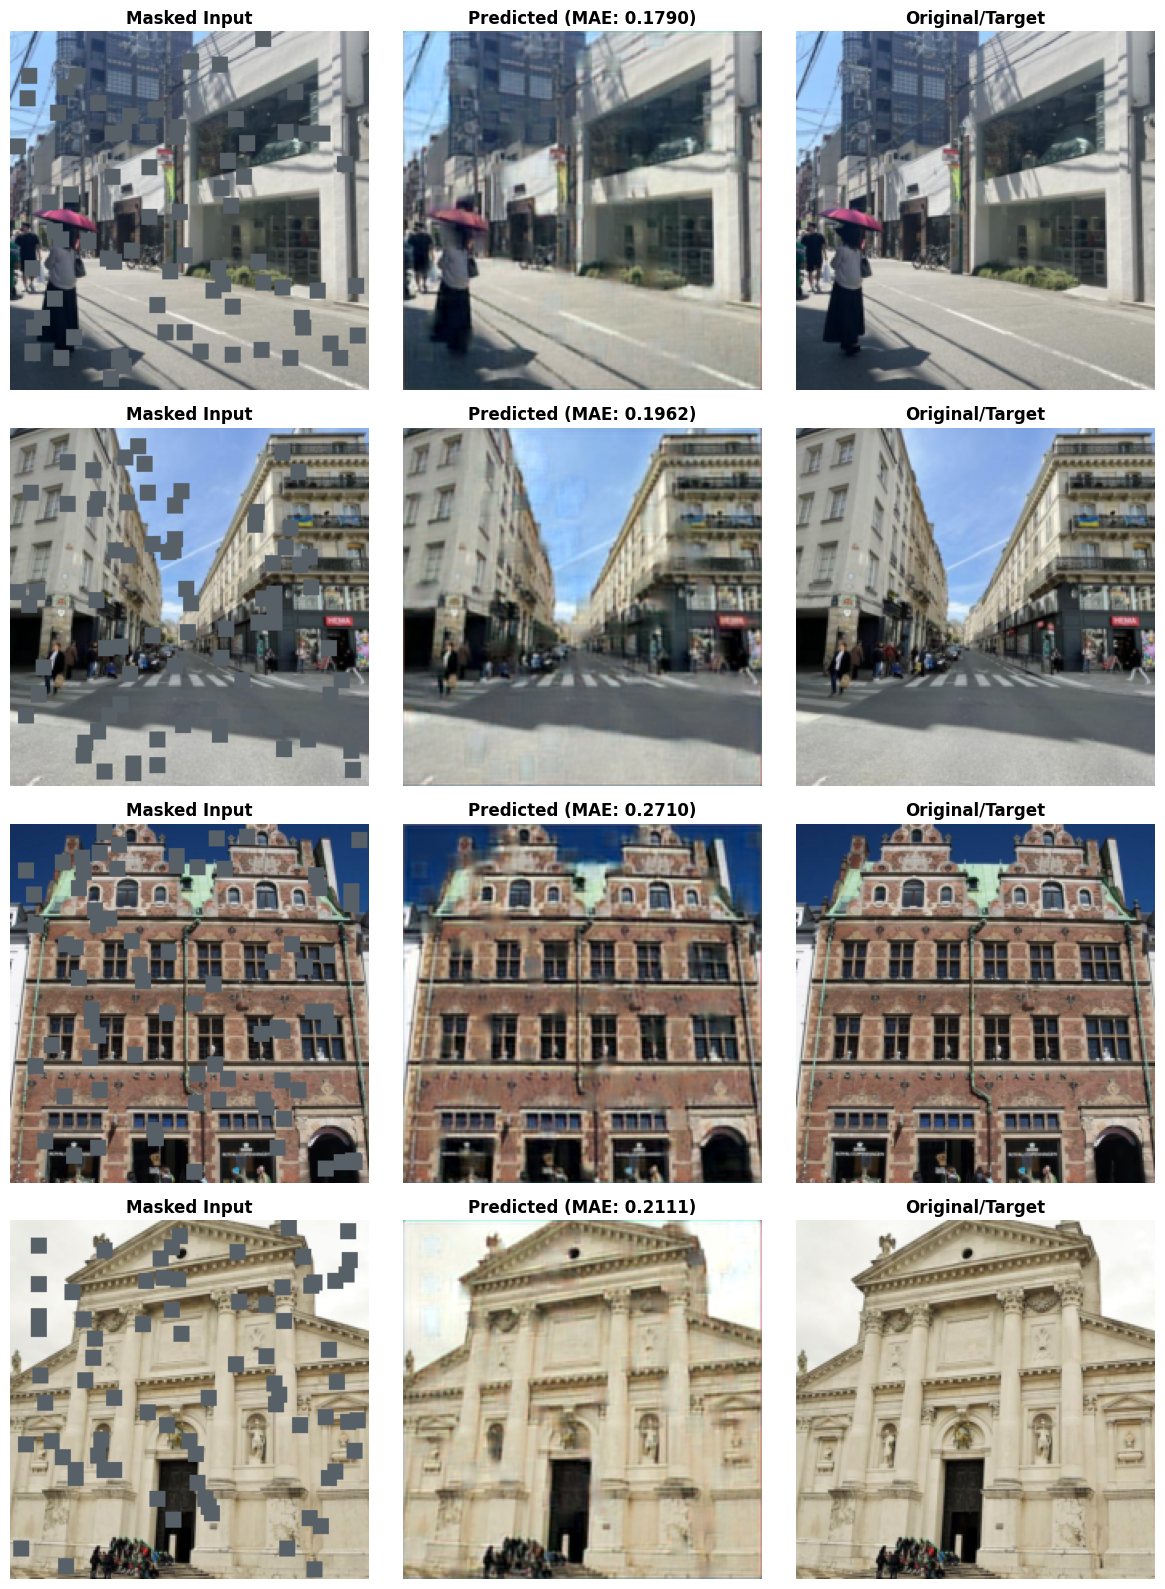

Results saved to 'inpainting_results.png'


In [12]:
model = LightningModule.load_from_checkpoint(
    'denoising_weights/version_1/checkpoints/best_valid_loss.ckpt',
    use_weighted_loss=True 
)

# Load your data
data_module = DataModule(dataset_name='urbanstevie/reference_dataset', bs=64)
data_module.setup()

# Visualize results
device = 'cuda' if torch.cuda.is_available() else 'cpu'
visualize_inpainting(
    model=model,
    dataloader=data_module.test_dataloader(),
    device=device,
    num_images=4
)

Repo card metadata block was not found. Setting CardData to empty.


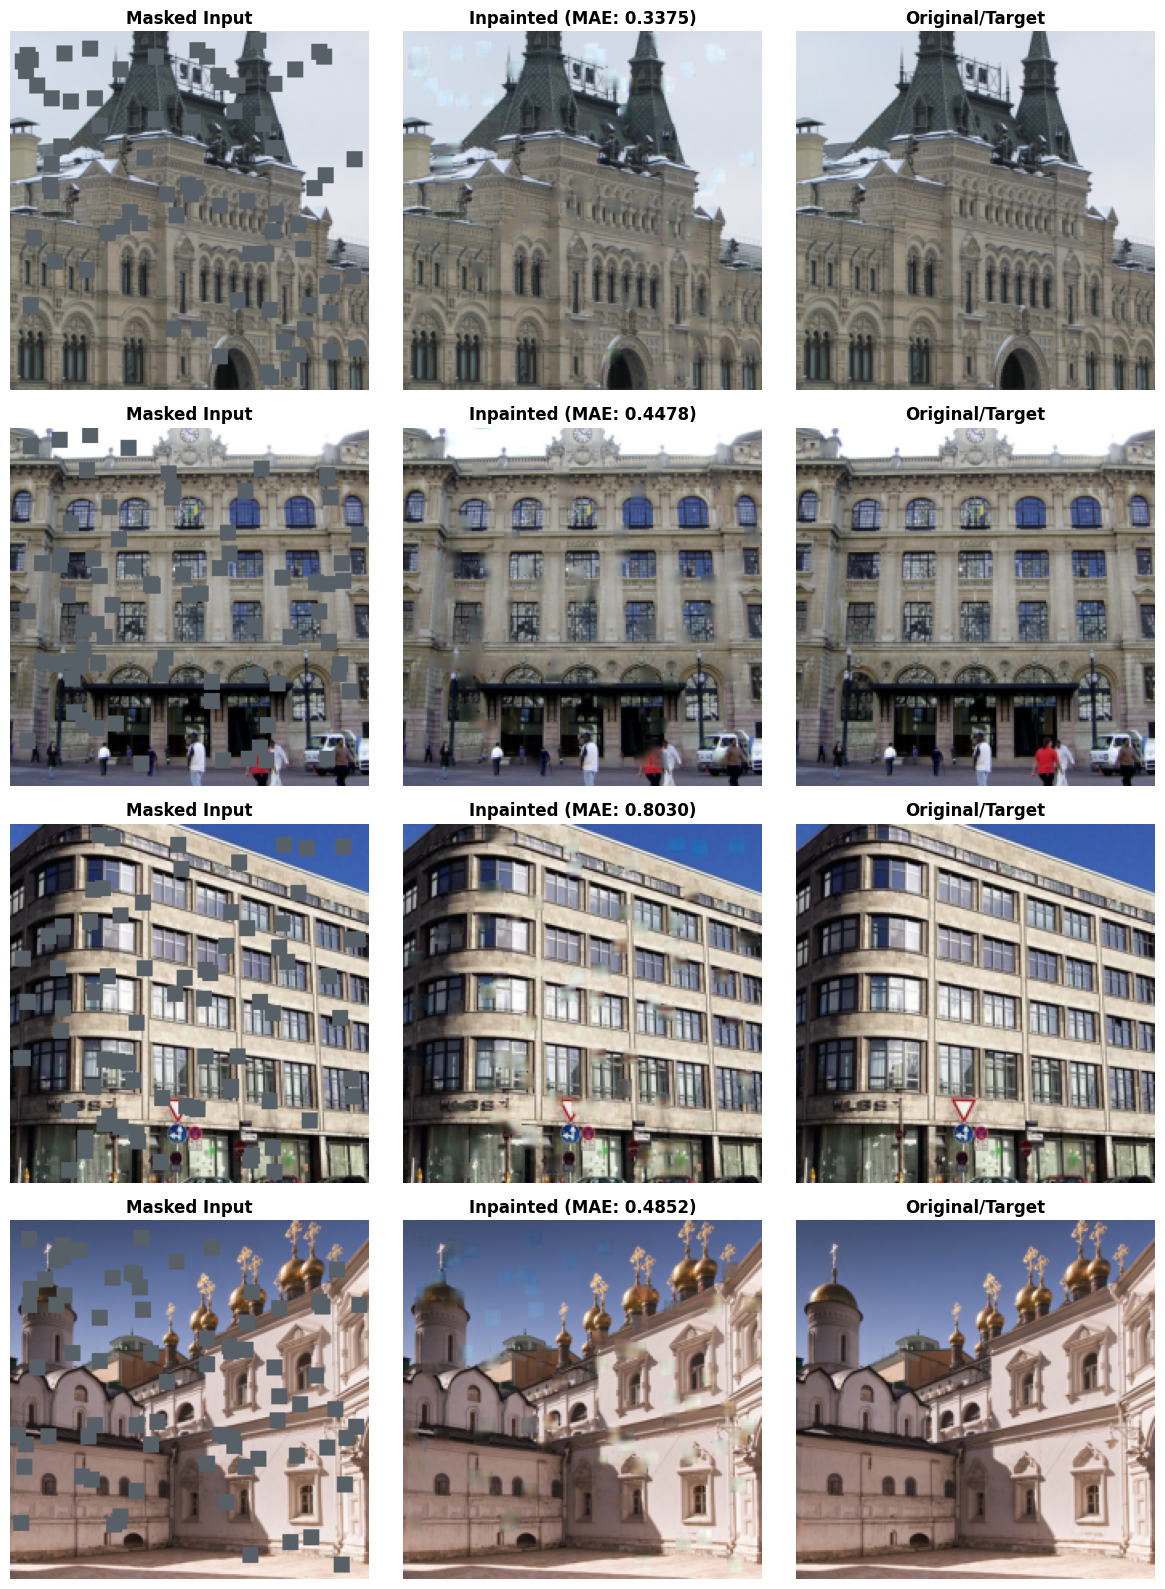

Results saved to 'inpainting_results.png'


In [13]:

def denormalize(img, mean, std):
    """Denormalize image for visualization"""
    img = img.clone()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    return img.clamp(0, 1)

def visualize_inpainting(model, dataloader, device='cuda', num_images=4):
    """
    Visualize inpainting results
    
    Args:
        model: Trained PyTorch Lightning model
        dataloader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        num_images: Number of images to visualize
    """
    model.eval()
    model.to(device)
    
    # Get normalization parameters (match your DataModule)
    mean = [0.34437724, 0.38029198, 0.40777111]
    std = [0.20265734, 0.13689059, 0.11554374]
    
    # Get a batch
    batch = next(iter(dataloader))
    masked_images = batch['masked_image'][:num_images].to(device)
    original_images = batch['original_image'][:num_images].to(device)
    masks = batch['mask'][:num_images].to(device)  # Mantener en GPU para operaciones
    
    # Get predictions
    with torch.no_grad():
        predicted_images = model(masked_images)
    
    # Crear imagen compuesta: masked image + predicted en las áreas enmascaradas
    # mask == 1 donde hay agujeros, mask == 0 donde está la imagen original
    composed_images = masked_images * (1 - masks) + predicted_images * masks
    
    # Move to CPU for visualization
    masked_images = masked_images.cpu()
    original_images = original_images.cpu()
    predicted_images = predicted_images.cpu()
    composed_images = composed_images.cpu()
    masks = masks.cpu()
    
    # Create figure
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4*num_images))
    
    # Handle single image case
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_images):
        # Denormalize images
        masked_img = denormalize(masked_images[i], mean, std)
        original_img = denormalize(original_images[i], mean, std)
        composed_img = denormalize(composed_images[i], mean, std)
        
        # Convert to numpy for plotting (C, H, W) -> (H, W, C)
        masked_np = masked_img.permute(1, 2, 0).numpy()
        original_np = original_img.permute(1, 2, 0).numpy()
        composed_np = composed_img.permute(1, 2, 0).numpy()
        
        # Calculate MAE only on masked regions
        mask_3ch = masks[i].expand(3, -1, -1)  # Expand mask to 3 channels
        mae_masked = (torch.abs(predicted_images[i] - original_images[i]) * mask_3ch).sum() / (mask_3ch.sum() + 1e-8)
        
        # Plot
        axes[i, 0].imshow(masked_np)
        axes[i, 0].set_title('Masked Input', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(composed_np)
        axes[i, 1].set_title(f'Inpainted (MAE: {mae_masked:.4f})', fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(original_np)
        axes[i, 2].set_title('Original/Target', fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('inpainting_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Results saved to 'inpainting_results.png'")

# Load your trained model
model = LightningModule.load_from_checkpoint(
    'denoising_weights/version_1/checkpoints/best_valid_loss.ckpt',
    use_weighted_loss=True  # Importante: mantener consistencia con el entrenamiento
)

# Load your data
data_module = DataModule(dataset_name='urbanstevie/reference_dataset', bs=64)
data_module.setup()

# Visualize results
device = 'cuda' if torch.cuda.is_available() else 'cpu'
visualize_inpainting(
    model=model,
    dataloader=data_module.test_dataloader(),
    device=device,
    num_images=4
)